In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment #the Hungarian method, O(n^3)
from os import listdir
from os.path import isfile, join
import time

In [3]:
# match the target img to all base descriptors and reture lowest cost (and the cost dictionary as well for test) 
def recognize(target, desc_path='image/descriptors', bin_r=5, bin_theta=12, r=2, n_samplePoints = 50):
    if not isinstance(target, np.ndarray):
        if isfile(target):
            target = cv2.imread(target)
    
    desc_t = computeDescriptor(target, bin_r, bin_theta, r, n_samplePoints)
    costs = {}
    desc_list = listdir(desc_path)
    for i, fname in enumerate(desc_list):
         if isfile(join(desc_path, fname)):
            desc_s = np.load(desc_path+'/'+fname)
#             if not desc_s.shape == desc_t.shape:
#                 print("Target and base escriptor shapes must match")
#                 return None, None
            cMatrix = computeCostMatrix_chi2(desc_s, desc_t)
            cost,_,_ = computeMinCost(cMatrix)
            costs[fname[0]] = round(cost, 2)
    return min(costs, key=costs.get), costs

In [4]:
# Compute the difference of two imgs, for debug
def computeDiff(source, target, bin_r=5, bin_theta=12, r=2, n_samplePoints = 50):
    desc_s = computeDescriptor(source, bin_r, bin_theta, r, n_samplePoints)
    desc_t = computeDescriptor(target, bin_r, bin_theta, r, n_samplePoints)
    cMatrix = computeCostMatrix_chi2(desc_s, desc_t)
    return computeMinCost(cMatrix)

In [5]:
# Plot the histogram of ONE point in a descriptor, for debug and demo
def plotDescriptorHist(des_per_point):
    plt.pcolormesh(np.flip(des_per_point, 0), cmap='Greys')
    plt.xlabel('θ')
    plt.ylabel('log r')
    plt.colorbar()
    plt.show()
    
# plotDescriptorHist(descriptor[0])

In [6]:
#Compute shape context descriptor of standard size (number of bins) and radius of 2 (eu distance)
#return: a descriptor (size: n_samplePoints * bin_r * bin_theta)
def computeDescriptor(img, bin_r=5, bin_theta=12, r=2, n_samplePoints = 50):
    #convert to gray img
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # binarize img (or not) and take edges
#     img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    edge = cv2.Canny(img, 250, 300)# 250 300
#     #take edge points from canny edge directly
#     contour_indices = []
#     for index, val in np.ndenumerate(edge):
#         if val == 255:
#             contour_indices.append((index[1],index[0]))
#     contour_indices = np.array(contour_indices).reshape((-1, 2)).tolist()

    #***instead, use contour points found by findContours() ***
    contours,_ = cv2.findContours(edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    #init array of all contour point coordinates
    contour_indices = np.array(contours[0]).reshape((-1, 2))

    #add all contour point coordinates
    for i in range(1,len(contours)):
        contour_indices = np.concatenate([contour_indices, np.array(contours[i]).reshape((-1, 2))], axis=0)
    contour_indices = contour_indices.tolist()
    
#     #show intermedia result, for debug only
#     ret = np.zeros(img.shape)
#     h,w = img.shape
#     for [x,y] in contour_indices:
#     #     if y<h and x<w:
#             ret[y][x] = 255
#     plt.imshow(ret)

    #sample some of contour points
    n_contourPoints = len(contour_indices)

#     #randomly sample points, follow uniform distribution (bad idea)
#     samplePoints_indices = np.random.choice(range(n_contourPoints), n_samplePoints)
#     samplePoints = []
#     for i in samplePoints_indices:
#         samplePoints.append(contour_indices[i])
    #iteratively and uniformly choose n contour points
    samplePoints = []
    for i in range(0, n_contourPoints, round(n_contourPoints/n_samplePoints)):
        samplePoints.append(contour_indices[i])
    samplePoints = samplePoints[:n_samplePoints]

    if len(samplePoints)<n_samplePoints:
        #if points not enough, fill with meanless points 
#         print("total points less than required:",n_samplePoints-len(samplePoints))
        samplePoints = samplePoints + (n_samplePoints-len(samplePoints))*[[0,0]]
    
#      #show intermedia result, for debug only
#     ret = np.zeros(img.shape)
#     h,w = img.shape
#     for [x,y] in samplePoints:
# #         if y<h and x<w:
#             ret[y][x] = 255
#     plt.imshow(ret)
    
    #init descriptor of all points, 5 * 12 bins for each point
    descriptor = np.zeros((n_samplePoints, bin_r, bin_theta), dtype=int)
    #compute eu dists and normalize by mean (a symmetric matrix)
    euclidians = cdist(samplePoints, samplePoints, metric='euclidean')
    normalized_euclidians = euclidians / euclidians.mean()
    #declare logspace bonds
    r_log = np.logspace(np.log10(0.125), np.log10(r), bin_r)

    #categorize eu dists radius-wise (5 categories) for each point, and store together in eu_rw
    #*** the outer most layer belongs to cate 1 ***
    eu_rw = np.zeros((n_samplePoints, n_samplePoints), dtype=int)
    for i in range(bin_r):
    #     for m in range(n_samplePoints):
    #         for n in range(n_samplePoints):
    #             eu_rw[m][n] += (normalized_euclidians[m][n]<r_log[i]) 
        eu_rw += normalized_euclidians<r_log[i] #O(n^2) matrix op

    #compute angles inter-points and normalize by *** vector of max dist points *** 
    thetas = cdist(samplePoints, samplePoints, metric=lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
#     maxPoints = [euclidians.argmax()//n_samplePoints, euclidians.argmax()%n_samplePoints]
#     normAngle = thetas[maxPoints[0], maxPoints[1]]
    #rotate by normAngle,convert to positive,and ignore small values
    for i in range(n_samplePoints):
        for j in range(n_samplePoints):
#             thetas[i][j] -= normAngle*(thetas[i][j]!=0)# if thetas[i][j]!=0
            thetas[i][j] += 2*math.pi*(thetas[i][j]<0)# if thetas[i][j]<0
            thetas[i][j] = thetas[i][j]*(thetas[i][j]>1e-7)# if thetas[i][j]>1e-7

    #categorize angles from 0 to 2*pi by a factor of bin_theta (default: 12) for each point, 
    #and store together in theta_aw. 
    theta_aw = np.int32(thetas/(2*math.pi/bin_theta)) #O(n^2) matrix op

    #fill in the descriptor
    for i in range(n_samplePoints):
        desc_per_point = np.zeros((bin_r, bin_theta)) 
        for j in range(n_samplePoints):
            if eu_rw[i][j]:# 0 means eu dist exceeds the radius of descriptor
                desc_per_point[eu_rw[i][j]-1, theta_aw[i][j]] += 1
        descriptor[i][:][:] = desc_per_point[:][:]    
    return descriptor


In [7]:
#compute chi square cost of two descripter
def computeCostMatrix_chi2(source, target):
    assert(source.shape==target.shape)
    l,h,w = source.shape # 50*5*12 default
    c = np.zeros((l, l), dtype=float)
    for i in range(l):
        for j in range(l):
            for m in range(h):
                for n in range(w):
                #assert non-zero denominator
                    if (source[i][m][n]+target[j][m][n]):
                        c[i][j] += 0.5*((source[i][m][n] - target[j][m][n])**2)/(source[i][m][n] + target[j][m][n])
    return c

def computeMinCost(c):
    rows, cols = linear_sum_assignment(c)
    cost = 0
    for i in range(len(rows)):
        cost += c[rows[i]][cols[i]]
    return cost, rows, cols

In [8]:
#*** Computes all the descriptors of bases and save into numpy array files ***
# Unnecessary to execute multiple times as long as no change to the base imgs
def computeBases(bin_r=5, bin_theta=12, r=2, n_samplePoints = 50):
    
    base_path = 'image/base'
    desc_path = 'image/descriptors'

    #compute descriptors of all base imgs and save into file
    for fname in listdir(base_path):
        if isfile(join(base_path, fname)):
            baseImg = cv2.imread(base_path+'/'+fname, cv2.IMREAD_GRAYSCALE)
            imgDesc = computeDescriptor(baseImg, bin_r, bin_theta, r, n_samplePoints)
            np.save(desc_path+'/'+fname[0]+'_desc',imgDesc)

In [9]:
# computeBases()

In [ ]:
# test for histogram demo, least-cost assignment, running time benchmark
def showHistogram():
    baseA = cv2.imread('image/base/A.png', cv2.IMREAD_GRAYSCALE)
    testA = cv2.imread('image/test_A.png', cv2.IMREAD_GRAYSCALE)
    testA = computeDescriptor(testA, bin_r, bin_theta, r, n_samplePoints)
    baseA = computeDescriptor(baseA, bin_r, bin_theta, r, n_samplePoints)
    start = time.time()
    cMatrix = computeCostMatrix_chi2(baseA,testA)
    cost,rows,cols = computeMinCost(cMatrix)
    print("time spend:", round((time.time()-start), 2), "s")
    print(rows)
    print(cols)
    plotDescriptorHist(baseA[rows[0]])
    plotDescriptorHist(testA[cols[0]])

    plotDescriptorHist(baseA[rows[5]])
    plotDescriptorHist(testA[cols[5]])

In [10]:
# The main program, runnable after all other function blocks are compiled.

# img = cv2.imread('image/A.png')
# plt.imshow(img)

baseA = cv2.imread('image/base/A.png', cv2.IMREAD_GRAYSCALE)
testA = cv2.imread('image/test_A.png', cv2.IMREAD_GRAYSCALE)
testB = cv2.imread('image/test_B.png', cv2.IMREAD_GRAYSCALE)
test9 = cv2.imread('image/test_9.png', cv2.IMREAD_GRAYSCALE)
testK = cv2.imread('image/test_K.png', cv2.IMREAD_GRAYSCALE)
testD = cv2.imread('image/test_D.png', cv2.IMREAD_GRAYSCALE)
# testB_r = cv2.imread('image/test_B_rotated.png')
# testA_r = cv2.imread('image/test_A_rotated.png')


bin_r=5
bin_theta=12
r=2
n_samplePoints = 50

# test for character recognition

result, cost_dict = recognize(testK)
print(cost_dict)
print("The character is ",result)

{'0': 647.55, '1': 1063.22, '2': 790.09, '3': 767.0, '4': 599.36, '5': 649.24, '6': 602.82, '7': 960.0, '8': 542.37, '9': 749.44, 'A': 500.93, 'B': 575.76, 'C': 798.49, 'D': 643.58, 'E': 717.49, 'F': 818.4, 'G': 670.82, 'H': 589.85, 'J': 990.24, 'K': 447.97, 'L': 815.41, 'M': 496.53, 'N': 490.86, 'R': 487.58, 'T': 967.48, 'X': 633.42}
The character is  K


time spend: 0.81 s
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[25 14 13 12  1 10  9 15  7  6  5  4  3  2 16 18 48 47 46 45  0 43 24 41
 26 27 28 37 36 31 32 33  8 35 30 29 38 39 40 11 42 23 44 22 21 20 19 17
 49 34]


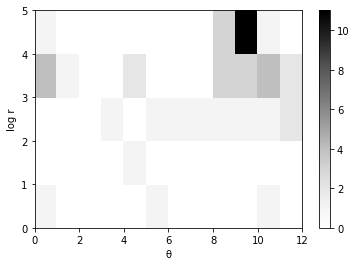

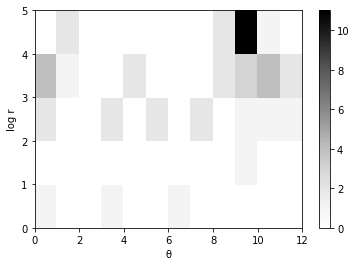

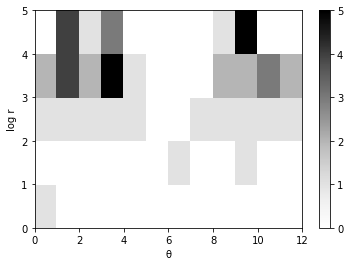

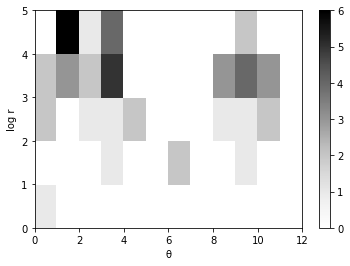

In [11]:
showHistogram()

In [12]:
# ret = np.zeros(img.shape)
# h,w = img.shape
# for [x,y] in samplePoints:
# #     if x<h and y<w:
#     ret[y][x] = 255
# plt.imshow(ret)



# edge = cv2.Canny(img, 50, 150)
# # plt.imshow(edge)
# samplePoints = []
# for index, val in np.ndenumerate(edge):
#     if val == 255:
#         samplePoints.append(index)

# print(samplePoints)
# for (x,y) in samplePoints:
#     ret[x][y] = 1
# plt.imshow(ret)

# ret = np.zeros(img.shape)
# h,w = img.shape
# for [x,y] in samplePoints:
# #     if x<h and y<w:
#     ret[y][x] = 255
# plt.imshow(ret)

# edge = cv2.Canny(img, 50, 150)
# # plt.imshow(edge)
# samplePoints = []
# for index, val in np.ndenumerate(edge):
#     if val == 255:
#         samplePoints.append(index)






# cost,_,_ = computeDiff(imgB, testB, bin_r, bin_theta, r, n_samplePoints)
# print(cost)

# baseA = computeDescriptor(imgA, bin_r, bin_theta, r, n_samplePoints)
# np.save("image/descriptors/A_desc",baseA)
# baseA_l = np.load("image/base/A_desc.npy")
# baseA == baseA_l

# baseB = computeDescriptor(imgB, bin_r, bin_theta, r, n_samplePoints)

# # dTestA = computeDescriptor(testA, bin_r, bin_theta, r, n_samplePoints)
# dTestB = computeDescriptor(testB, bin_r, bin_theta, r, n_samplePoints)


# cMatrix = computeCostMatrix_chi2(baseA,dTestB)
# cost,_,_ = computeMinCost(cMatrix)
# print(cost)

# cMatrix = computeCostMatrix_chi2(baseB,dTestB)
# cost,_,_ = computeMinCost(cMatrix)
# print(cost)

In [13]:
# print(len(samplePoints)==n_samplePoints)
# r = 2
# bin_r=5
# bin_theta=12
# #init descriptor of all points, 5 * 12 bins for each point
# descriptor = np.zeros((n_samplePoints, bin_r, bin_theta), dtype=int)
# #compute eu dists and normalize by mean (a symmetric matrix)
# euclidians = cdist(samplePoints, samplePoints, metric='euclidean')
# normalized_euclidians = euclidians / euclidians.mean()
# #declare logspace bonds
# r_log = np.logspace(np.log10(0.125), np.log10(r), bin_r)

# #categorize eu dists radius-wise (5 categories) for each point, and store together in eu_rw
# #*** the outer most layer is cate 1 ***
# eu_rw = np.zeros((n_samplePoints, n_samplePoints), dtype=int)
# for i in range(bin_r):
# #     for m in range(n_samplePoints):
# #         for n in range(n_samplePoints):
# #             eu_rw[m][n] += (normalized_euclidians[m][n]<r_log[i]) 
#     eu_rw += normalized_euclidians<r_log[i] #O(n^2) matrix op

# #compute angles inter-points and normalize by *** vector of max dist points *** 
# thetas = cdist(samplePoints, samplePoints, metric=lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
# maxPoints = [euclidians.argmax()//n_samplePoints, euclidians.argmax()%n_samplePoints]
# normAngle = thetas[maxPoints[0], maxPoints[1]]
# #rotate by normAngle,convert to positive,and ignore small values
# for i in range(n_samplePoints):
#     for j in range(n_samplePoints):
#         thetas[i][j] -= normAngle*(thetas[i][j]!=0)
#         thetas[i][j] += 2*math.pi*(thetas[i][j]<0)
#         thetas[i][j] = thetas[i][j]*(thetas[i][j]>1e-7)
        
# #categorize angles from 0 to 2*pi by a factor of 12, for each point, and store together in theta_aw
# theta_aw = np.int32(thetas/(2*math.pi/bin_theta))

# #compute values in descriptor
# for i in range(n_samplePoints):
#     desc_per_point = np.zeros((bin_r, bin_theta)) 
#     for j in range(n_samplePoints):
#         if eu_rw[i][j]:# 0 means eu dist exceeds the radius of descriptor
#             desc_per_point[eu_rw[i][j]-1, theta_aw[i][j]] += 1
#     descriptor[i][:][:] = desc_per_point[:][:]    



